Calculate poleward heat transport given individual 2nd order components calculated at high time res during diagnostics of model run.

Variables are: v*T, v*Q, v*gZ, v*u^2
      <li>Merid transport of: sensible heat, latent heat, potential energy (geopotential), kinetic energy (zonal mom)</li>
To get into units of energy, multiply by:
      <li>Cp, Lv, (already mult by g), 1/2 for the four components respectively</li>
      
Then, total transport in e/ grid cell: Ev = Cp*T*v + Lv*Q + gZ*v + 1/2*u^2*v
      
<i>Integrate vertically and average zonally</i> to get a standard Total Atmospheric Poleward Heat Transport.
See for example, Wuncsh 2005 (JClim), Fasullo & Trenberth 2008 (JClim)

Other options are vertically integrate and zonally integrate (e.g. Yang et al 2010, GRL)<br>
Or vertically and zonally average (e.g. Peixoto & Oort text, 1992).

<b>Also</b>, vertical integrals and averages of 2nd order vars were also computed during diagnostics at high time res. Test these variables too, and compare to the above. 

<b>At present, the resulting calculation for total PHT (vertically integrated and zonally averaged) is one order of magnitude too small when compared to e.g. Wuncsh 2005 (JClim), Fasullo & Trenberth 2008 (JClim).</b>

In [1]:
# Maybe use this notebook for saving data in .mat format. 
# Make comparison figures in another notebook


# ============ METADATA ==========================
# ================================================
#   meridional_sens_heat_flux: # m/s * C (mult by Cp to get (m/s)(J/kg)
# 
#   zonal_sens_heat_flux: # m/s * C (mult by Cp to get (m/s)(J/kg)
#
#   meridional_latent_heat_flux: m/s * kg/kg (mult by Lv to get (m/s)(J/kg))
#
#   meridional_potential_energy_flux: m/s * (m2/s2) ---> m/s * (J/kg)
#     geopotential is the gravitational potential energy per unit mass at that elevation h
#     The field 'gz', or PHI, is geopotential height * gravity, which is geopotential. 
#     Z = PHI/g0, where Z is geopotential height and g0 is standard gravity. 
#     https://en.wikipedia.org/wiki/Geopotential_height
#
#   (kinetic energy) meridional_flux_zonal_mom: m/s * (m2/s2) 
#       --> KE is 1/2 mv^2 which is kg m2/s2.
#       so what we have is KE per kg. ---> m/s * (J/kg)


# =============== ALGORITHM =========================
# calc the vertical integral of poleward energy transport across 
#    a latitude in units of Watts
#
#   (Zonal total transport)
# = 1/g int_pbot_to_ptop[  int_latcircle[ E*v a coslat dlon dp]]. 
#      a is Earth's radius, E is total energy (SH, LH, PE, KE) in (m/s)(J/kg)
#
#   (Zonal average transport)
# = 1/g int_pbot_to_ptop[  int_latcircle[ E*v a coslat dlon dp]/totlon ]. 



import cccmautils as cutl
import constants as con
import pandas as pd
import numpy.ma as ma
import scipy.io as sio
%matplotlib inline

# For each sim: Run this with savemat=True for timeseries=True and =False

printtofile=False
calctype='vertint' # 'vertint' or 'vertavg', for calc'ing PHT in script


savemat = False # else, load .mat
matdir = '/HOME/rkm/pyscripts/pymatfiles/' # save to mat now scrambles the data somehow
npydir = '/HOME/rkm/pyscripts/pynpyfiles/'
timeseries = True # save timeseries mat instead of time avg


#  ===== set up input file and calculation info =====

domonth=False # otherwise do season
sea='ANN'
mo=1

if domonth:
    seasonalizedt={'mo':mo}
else:
    seasonalizedt={'season':sea}

if calctype=='vertint': 
    fldpre = '_vert_int' # calc already done in .nc file 
else: 
    fldpre = '_vert_avg' # calc already done in .nc file 
        

basedir='/HOME/rkm/work/DATA/CanESM2/'
fldsuff=''

#full100 yrs is too big for 4D fields
#casename='preipreiice'; timeper = '3022-3121'; timesel='3022-01-01,3121-12-31' #timeper = '2972-3071'; timesel='2972-01-01,3071-12-31' 
#casename='prei2xco2iceb'; timeper = '3022-3121'; timesel='3022-01-01,3121-12-31' #timeper = '2972-3071'; timesel='2972-01-01,3071-12-31';
#casename='pi2xco2ipulse'; timeper = '2921-3021'; timesel='2922-01-01,3021-12-31' 
#casename='2xco22xco2ice'; timeper = '2552-2651'; timesel='2552-01-01,2651-12-31' #timeper = '2451-2551'; timesel='2452-01-01,2551-12-31'
#casename='2xco2preiice'; timeper = '2652-2751'; timesel='2652-01-01,2751-12-31' 

casename='2xco2preiice'; timeper = '2552-2751'; timesel='2552-01-01,2751-12-31' # 200yr for .npy only @@@@


basepath=basedir+casename+'/ts/'
ncfield='MLT'

if timeseries:
    ttype='timeseries'
else:
    ttype='climo'

# ===== set up constants and conversions =====

Cp=1004 # specific heat at const pressure (J/K/kg)
Lv=2.5e6 # specific heat of condensation (latent heat of vapo) at 0C(?@@) (J/kg)
erad = con.get_earthrad() # m
grav = con.get_g() # m/s2

# 1 cal = 4.186J
# convert to cal / day
# J/s -> cal/day
W2calperday = (60*60*24)/4.186


# ===== get coordinate and util data =====
lat = con.get_t63lat()
lon = con.get_t63lon()
#lev = con.get_t63lev() # 37 levs
# temp file to get level
fname=basedir + 'preipreiice/ts/preipreiice_u_2921-3021_ts.nc' # 22 levs
lev = cnc.getNCvar(fname,'plev')
dp = np.diff(lev)
nlon = len(lon)-1 # removing extra lon for zonal calcs

In [4]:
# get surface pressure to do vert avg and int
fname=basepath + casename + '_ps_' + timeper + '_ts.nc'
if savemat:
    sfcp = cnc.getNCvar(fname,'PS',timesel=timesel)*100 # into Pa
    matname = matdir + 'PHT/PS_' + casename + '_' + \
              sea + '_timeseries' + timeper +'.mat' 
    sio.savemat(matname, {'PS':sfcp})
else:
    matname = matdir + 'PHT/PS_' + casename + '_' + \
              sea + '_timeseries' + timeper +'.mat'
    print 'load ' + matname
    sfcp = sio.loadmat(matname, squeeze_me=True)['PS']

load /HOME/rkm/pyscripts/pymatfiles/PHT/PS_2xco2preiice_ANN_timeseries2652-2751.mat


In [2]:
# ====== DEFINE FUNCTIONS =============
def clear_belowsfc(fld, sfcp, lev):
    """ if the surface pressure is less than a pressure level of data,
           then the data is below the surface and should be masked.
           
            fld: input data with level coord. [time x lev x ...]
            sfcp: surface pressure with same dimensions as fld
            lev: the plev coordinate
            
            returns: fld with data below surface masked out
    """
    
    for levii,level in enumerate(lev):
        # for each level, mask where surface pressure is less than
        #    level pressure 
        fld[:,levii,...] = ma.masked_where(sfcp<level,fld[:,levii,...])

    return fld

def calc_PHT(fld, onelat, dp=None, vcalc='vertint',zcalc='zonavg', withtime=False):
    """
         calculates zonal AVERAGE/or zonal INTEGRAL of 
         vertical INTEGRAL or vertical AVERAGE.
         
            input data (fld) may already have vertical dimension taken care of.
              If so, set vcalc='none'

            fld: calculate meridional energy trans in [W] from this field. 
                 coords [[lev] x lon]
            onelat: latitude at which to calc the meridional energy trans (in deg)
            dp: difference in level coords (lev.diff()) [Pa] 
                Only necessary for vcalc != 'none'
            
            vcalc='vertint' calculates vertical integral w/ pressure
            vcalc='vertavg' calculates vertical average w/ pressure
            vcalc='none' no vertical calc b/c already vertically integrated/averaged

            zcalc='zonint' calculates zonal integral
            zcalc='zonavg' calculates zonal average
            
            withtime: if True, time is the first dimension

         Vertical dim is done first, then zonal.
             
         returns poleward heat transport in Watts [scalar] 
    """

    # dims of fld will be: lev x lon
    #   OR  x lon

    if withtime:
        return calc_PHT_withtime(fld, onelat, dp=dp, vcalc=vcalc, zcalc=zcalc)
    else:
        nlon = fld.shape[-1]
        latrad = np.deg2rad(onelat) # latitude in radians
        totlam=2*np.pi # sum of radians in zonal dim
        dlam=totlam/np.float(nlon) # delta lambda (diff in radians per lon cell)

        if vcalc == 'none':
            # this means the vertical dimension has already been
            #  taken care of in the .nc file
            tmpfld = fld # div by g done in .nc file

        elif vcalc=='vertint':
            # do a VERTICAL INTEGRAL (first dim of fld)
            #  tile dp
            dpt=np.tile(dp,(nlon,1)).T
            #  interp fld in b/w levels
            tmpfld= (fld[0:-1,...] + fld[1:,...]) / 2. 
            # integrate and divide by g
            tmpfld = ma.sum(tmpfld*dpt,axis=0)/grav
            # now it's  [x lon]

        elif vcalc=='vertavg':
            # do a VERTICAL AVERAGE (first dim of fld)
            #  tile dp
            dptot=np.sum(dp) # total amount of pressure for weights
            # create vertical weights and tile them w/ lon
            dpw=np.tile(dp/np.float(dptot),(nlon,1)).T # [lev x lon]
            #  interp fld in b/w levels
            tmpfld= (fld[0:-1,...] + fld[1:,...]) / 2. 
            # average and divide by g (@@?? div by g?)
            tmpfld = ma.average(tmpfld, axis=0, weights=dpw)/grav
            # now it's  [x lon]

        else:
            print 'vcalc type not supported' 
            return -1

        # zonal integration
        fldpint = ma.sum(tmpfld)*erad*np.cos(latrad)*dlam 

        if zcalc=='zonint':
            pass # zonal integral is done
        elif zcalc=='zonavg':
            # do the ZONAL AVERAGE
            fldpint = fldpint / totlam
        else:
            print 'zcalc type not supported' 
            return -1

        return fldpint


def calc_PHT_withtime(fld, onelat, dp=None, vcalc='vertint',zcalc='zonavg'):
    """
         calculates zonal AVERAGE/or zonal INTEGRAL of 
         vertical INTEGRAL or vertical AVERAGE. Assumes time is first dim!
         
            input data (fld) may already have vertical dimension taken care of.
              If so, set vcalc='none'

            fld: calculate meridional energy trans in [W] from this field. 
                 coords [time x [lev] x lon]
            onelat: latitude at which to calc the meridional energy trans (in deg)
            dp: difference in level coords (lev.diff()) [Pa] 
                Only necessary for vcalc != 'none'
            
            vcalc='vertint' calculates vertical integral w/ pressure
            vcalc='vertavg' calculates vertical average w/ pressure
            vcalc='none' no vertical calc b/c already vertically integrated/averaged

            zcalc='zonint' calculates zonal integral
            zcalc='zonavg' calculates zonal average

         Vertical dim is done first, then zonal.
             
         returns poleward heat transport in Watts [scalar] 
    """

    # dims of fld will be: time x lev x lon
    #   OR  time x lon

    ntime = fld.shape[0]
    nlon = fld.shape[-1]
    latrad = np.deg2rad(onelat) # latitude in radians
    totlam=2*np.pi # sum of radians in zonal dim
    dlam=totlam/np.float(nlon) # delta lambda (diff in radians per lon cell)

    if vcalc == 'none':
        # this means the vertical dimension has already been
        #  taken care of in the .nc file
        tmpfld = fld # div by g done in .nc file

    elif vcalc=='vertint':
        # do a VERTICAL INTEGRAL (first dim of fld)
        #  tile dp
        dpt=np.tile(dp,(ntime,nlon,1))
        dpt = np.transpose(dpt,(0,2,1))
        #print 'withtime SHAPE dpt ' + str(dpt.shape) # @@@
        
        #  interp fld in b/w levels
        tmpfld= (fld[:,0:-1,...] + fld[:,1:,...]) / 2. 
        #print 'withtime SHAPE tmpfld ' + str(tmpfld.shape) # @@@
        # integrate and divide by g
        tmpfld = ma.sum(tmpfld*dpt,axis=1)/grav
        # now it's  [time x lon]

    elif vcalc=='vertavg':
        # do a VERTICAL AVERAGE (first dim of fld)
        #  tile dp
        dptot=np.sum(dp) # total amount of pressure for weights
        # create vertical weights and tile them w/ lon
        dpw=np.tile(dp/np.float(dptot),(ntime,nlon,1)) 
        dpw=np.transpose(dpw,(0,2,1))
        
        #  interp fld in b/w levels
        tmpfld= (fld[:,0:-1,...] + fld[:,1:,...]) / 2. 
        # average and divide by g (@@?? div by g?)
        tmpfld = ma.average(tmpfld, axis=1, weights=dpw)/grav
        # now it's  [time x lon]

    else:
        print 'vcalc type not supported' 
        return -1

    # zonal integration
    fldpint = ma.sum(tmpfld, axis=1)*erad*np.cos(latrad)*dlam 

    if zcalc=='zonint':
        pass # zonal integral is done
    elif zcalc=='zonavg':
        # do the ZONAL AVERAGE
        fldpint = fldpint / totlam
    else:
        print 'zcalc type not supported' 
        return -1

    # print 'fldpint SHAPE,type ' + str(fldpint.shape), str(type(fldpint)) #@@
    return fldpint
# =========== end functions ================

In [8]:
# ========== Read in 2nd order var components of PHT [3-D] =========
# ==========  vertical integral/average already in .nc file ======

# variable names in file
flddt={'MPEF': 'MLT',
       'MSHF': 'MLT',
       'MLHF': 'MLT',
       'MFZM': 'MLT'}
# conversion factors
condt={'MPEF': 1,
       'MSHF': Cp,
       'MLHF': Lv,
       'MFZM': 0.5} 

print 'Need to change the saving of .mat files to .npy! 7/22/2016 @@@'

if fldpre == '_vert_int':
    flddt2 = flddt
else:
    # variable name in file
    flddt2={'MPEF': 'DIV',
            'MSHF': 'DIV',
            'MLHF': 'DIV',
            'MFZM': 'DIV'}

fdict2={'MPEF': basepath + casename + fldpre + '_meridional_potential_energy_flux' + fldsuff +'_' + timeper + '_ts.nc',
       'MSHF': basepath + casename + fldpre + '_meridional_sens_heat_flux' + fldsuff + '_' + timeper + '_ts.nc',
       'MLHF': basepath + casename + fldpre + '_meridional_latent_heat_flux' + fldsuff + '_' + timeper + '_ts.nc',
       'MFZM': basepath + casename + fldpre + '_meridional_flux_zonal_mom' + fldsuff + '_' + timeper + '_ts.nc'}

fldintdt2={}; #fldintzadt2={}
for fkey in fdict2:
    
    ncfield=flddt2[fkey]
    
    fname=fdict2[fkey]
    conv=condt[fkey] 

    if savemat:
        fld=cnc.getNCvar(fname,ncfield,timesel=timesel)*conv
        print fname + ', fld.shape ' + str(fld.shape) # @@@
        nyr=fld.shape[0]/12
        if sea in ('DJF','NDJ'): nyr=nyr-1
        
        if timeseries:
            fldint=np.zeros((nyr,len(lat))) # time x lat
        else:
            fldint=np.zeros(len(lat))
        #fldintza=np.zeros(len(lat))
        for latidx,ll in enumerate(lat): # do all lats
            # get just one lat and remove extra lon
            fldsub = np.squeeze(fld[:,latidx,:-1]) 
            
            if timeseries: # do not time average
                fldtm = cutl.seasonalize(fldsub,**seasonalizedt)
                # zonal integration
                fldint[:,latidx] = calc_PHT(fldtm, ll, vcalc='none', zcalc='zonint', withtime=True) 
            else:
                # seasonal & time mean
                fldtm = np.mean(cutl.seasonalize_monthlyts(fldsub,**seasonalizedt),axis=0) 
                # zonal integration
                fldint[latidx] = calc_PHT(fldtm, ll, vcalc='none', zcalc='zonint') 
                

        fldintdt2[fkey] = fldint
        #fldintzadt2[fkey] = fldintza
    
        matname = matdir + 'PHT/' + fkey + 'fromnc_zonint_' + calctype +'_'+ casename + '_' + \
                  sea + '_' + ttype + timeper +'.mat' 
        sio.savemat(matname, {fkey:fldint})
        
    else: # load the mat files
        
        matname = matdir + 'PHT/' + fkey + 'fromnc_zonint_'+ calctype +'_' + casename + '_' + \
                  sea + '_' + ttype + timeper +'.mat'
        print 'load ' + matname
        fldintdt2[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]

Need to change the saving of .mat files to .npy! 7/22/2016 @@@
load /HOME/rkm/pyscripts/pymatfiles/PHT/MLHFfromnc_zonint_vertint_2xco2preiice_ANN_timeseries2652-2751.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MPEFfromnc_zonint_vertint_2xco2preiice_ANN_timeseries2652-2751.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MFZMfromnc_zonint_vertint_2xco2preiice_ANN_timeseries2652-2751.mat
load /HOME/rkm/pyscripts/pymatfiles/PHT/MSHFfromnc_zonint_vertint_2xco2preiice_ANN_timeseries2652-2751.mat


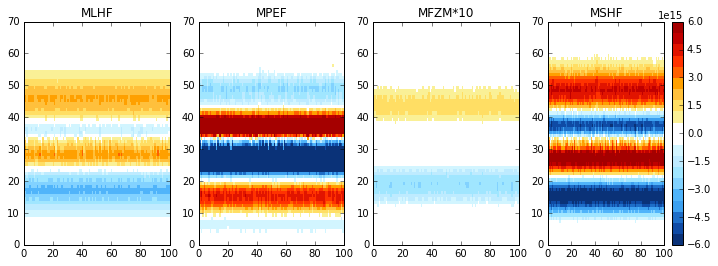

In [9]:
# DataFrame only works when it's a 1-D array. Not for time x lat.
# can't do any of this with full timeseries read in
cmap='blue2red_w20'


if timeseries:
    fldint2vals = fldintdt2.values()
    fldint2keys = fldintdt2.keys()
    
    pparams = {'cmap': plt.cm.get_cmap(cmap), 'vmin':-6e15, 'vmax': 6e15}
    
    kk = 0
    fig,axs = plt.subplots(1,4, figsize=(12,4))
    ax=axs[0]
    pc = ax.pcolor(fldint2vals[kk].T,**pparams)
    ax.set_title(fldint2keys[kk])
    
    kk = 1
    ax=axs[1]
    pc = ax.pcolor(fldint2vals[kk].T,**pparams)
    ax.set_title(fldint2keys[kk])
    
    kk = 2
    ax=axs[2]
    pc = ax.pcolor(fldint2vals[kk].T*10,**pparams)
    ax.set_title(fldint2keys[kk] + '*10')
    
    kk = 3
    #fig,ax = plt.subplots(1,1)
    ax=axs[3]
    pc = ax.pcolor(fldint2vals[kk].T,**pparams)
    plt.colorbar(pc)
    ax.set_title(fldint2keys[kk])
    
if not timeseries:
    # zonally integrated heat transport components
    flddf2 = pd.DataFrame(fldintdt2)
    # zonally integrated total atmospheric heat transport 
    fldtot2 = flddf2.sum(axis=1)



In [105]:
if False: # generally don't want to run b/c will get memory error. 
    
    # ========== Read in 2nd order var components of PHT [4-D] =========
    # ==========  vertical integral/average is done in function ========
    # ==================================================================

    # Skip this cell if a full timeseries (> about 40 years) @@@ Will get memory error...


    # filenames
    fdict={'MPEF': basepath + casename + '_meridional_potential_energy_flux' + fldsuff +'_' + timeper + '_ts.nc',
           'MSHF': basepath + casename + '_meridional_sens_heat_flux' + fldsuff + '_' + timeper + '_ts.nc',
           'MLHF': basepath + casename + '_meridional_latent_heat_flux' + fldsuff + '_' + timeper + '_ts.nc',
           'MFZM': basepath + casename + '_meridional_flux_zonal_mom' + fldsuff + '_' + timeper + '_ts.nc'}
    # variable names in file
    flddt={'MPEF': 'MLT',
           'MSHF': 'MLT',
           'MLHF': 'MLT',
           'MFZM': 'MLT'}
    # conversion factors
    condt={'MPEF': 1,
           'MSHF': Cp,
           'MLHF': Lv,
           'MFZM': 0.5} 


    # zonal integral #and zonal average
    fldintdt={}; #fldintzadt={}
    #  For each component, get data, calc poleward transport for e/ lat
    for fkey in fdict.keys():

        ncfield=flddt[fkey]

        fname=fdict[fkey]
        conv=condt[fkey] 

        if savemat:
            fld=cnc.getNCvar(fname,ncfield,timesel=timesel)*conv
            fld=clear_belowsfc(fld, sfcp, lev) # mask data below surface

            print fname + ', fld.shape ' + str(fld.shape) # @@@

            if timeseries:
                fldint=np.zeros((fld.shape[0]/12,len(lat))) # time x lat
            else:
                fldint=np.zeros(len(lat))
            #fldintza=np.zeros(len(lat))
            for latidx,ll in enumerate(lat): # do all lats
                # get just one lat and remove extra lon
                fldsub = np.squeeze(fld[:,:,latidx,:-1]) 
                print fldsub.shape #@@@@

                if timeseries: # do not time average
                    fldtm = cutl.seasonalize(fldsub,**seasonalizedt)
                    # zonal integration
                    fldint[:,latidx] = calc_PHT(fldtm, ll, dp=dp, vcalc=calctype, zcalc='zonint',withtime=True) 

                else:
                    # seasonal & time mean
                    fldtm = np.mean(cutl.seasonalize(fldsub,**seasonalizedt),axis=0) 
                    # zonal integration
                    fldint[latidx] = calc_PHT(fldtm, ll, dp=dp, vcalc=calctype, zcalc='zonint') 



            fldintdt[fkey] = fldint
            #fldintzadt[fkey] = fldintza

            matname = matdir + 'PHT/' + fkey + '_zonint_' + calctype +'_' + casename + '_' + \
                      sea + '_' + ttype + timeper +'.mat' 
            #print fldint
            sio.savemat(matname, {fkey:fldint})

        else: # load the mat files

            matname = matdir + 'PHT/' + fkey + '_zonint_' + calctype +'_'+ casename + '_' + \
                      sea + '_' + ttype + timeper +'.mat'
            print 'load ' + matname
            fldintdt[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]


    # DataFrame only works when it's a 1-D array. Not for time x lat.
    # can't do any of this with full timeseries read in
    if timeseries:
        # pick a latitude? or just leave as dictionary
        fldintvals = np.array(fldintdt.values())
        fldintkeys = fldintdt.keys()

        print fldintvals.shape # numkeys(4) x time x lat
        print fldintkeys

        kk = 0
        fig,ax = plt.subplots(1,1)
        pc = ax.pcolor(fldintvals[kk].T)
        plt.colorbar(pc)
        ax.set_title(fldintkeys[kk])

        kk = 3
        fig,ax = plt.subplots(1,1)
        pc = ax.pcolor(fldintvals[kk].T)
        plt.colorbar(pc)
        ax.set_title(fldintkeys[kk])


    if not timeseries:
        # zonally integrated heat transport components
        flddf = pd.DataFrame(fldintdt)
        # zonally integrated total atmospheric heat transport
        fldtot = flddf.sum(axis=1)

    if not timeseries: # this only works if the prev data is read in (the 4D)
        # Test if PHT sums to zero: zonal integral
        print 'in .nc. should sum to 0: ' + str(fldtot2.sum()/1e15) + ' PW'
        print '  This is ' + str(fldtot2.sum()/fldtot2.max()*100) +'% of max trans'
        print 'in func. should sum to 0: ' + str(fldtot.sum()/1e15) + ' PW'
        print '  This is ' + str(fldtot.sum()/fldtot.max()*100) +'% of max trans'

        fig,ax=plt.subplots(1,1)
        ax.plot(lat,fldtot,color='k',linewidth=2)
        ax.plot(lat,fldtot2,color='k',linewidth=2,linestyle='--')
        ax.legend(('Calc in func','Calc in .nc'),loc='best')
        ax.axhline(y=0,color='0.5')
        ax.axhline(y=fldtot.max(),color='r')
        ax.axhline(y=fldtot2.max(),color='r',linestyle='--')
        ax.axhline(y=fldtot.min(),color='b')
        ax.axhline(y=fldtot2.min(),color='b',linestyle='--')
        ax.set_xlim((-90,90))
        ax.set_title(casename)

    # ============ FIGURES =================

    print casename

    if not timeseries:

        printtofile=False
        #    calc in function
        #    ZONAL INTEGRAL, just NH --------------
        fig,axs=plt.subplots(1,2)
        fig.set_size_inches(11,5)
        ax=axs[0]
        flddf.plot(x=lat,ax=ax)
        ax.plot(lat,fldtot,color='k', linewidth=2)
        ax.axhline(y=0,color='0.5')
        ax.set_xlim((-15,75))
        ax.set_xlabel('latitude')
        ax.set_ylabel('(zonal integral) poleward transport (W)')
        ax.set_title(calctype + ' ' + sea + ' calc in script')    
        #    calc in .nc file
        #    ZONAL INTEGRAL, just NH
        ax=axs[1]
        flddf2.plot(x=lat, ax=ax)
        ax.plot(lat,fldtot2,color='k', linewidth=2)
        ax.axhline(y=0,color='0.5')
        ax.set_xlim((-15,75))
        ax.set_xlabel('latitude')
        ax.set_ylabel('(zonal integral) poleward transport (W)')
        ax.set_title(calctype + ' ' + sea + ' calc in .nc file')
        if printtofile:
            fig.savefig(casename + '_PHTnh_zonint_W_' + sea + fldpre + '.pdf')


        #    calc in function
        #    ZONAL INTEGRAL, GLOBAL --------------------
        fig,axs=plt.subplots(1,2)
        fig.set_size_inches(11,5)
        ax=axs[0]
        flddf.plot(x=lat,ax=ax)
        ax.plot(lat,fldtot,color='k', linewidth=2)
        ax.axhline(y=0,color='0.5')
        ax.set_xlim((-80,80))
        ax.set_xlabel('latitude')
        ax.set_ylabel('(zonal integral) poleward transport (W)')
        ax.set_title(calctype + ' ' + sea + ' calc in script')
        #    calc in .nc file
        #    ZONAL INTEGRAL, GLOBAL
        ax=axs[1]
        flddf2.plot(x=lat, ax=ax)
        ax.plot(lat,fldtot2,color='k', linewidth=2)
        ax.axhline(y=0,color='0.5')
        ax.set_xlim((-80,80))
        ax.set_xlabel('latitude')
        ax.set_ylabel('(zonal integral) poleward transport (W)')
        ax.set_title(calctype + ' ' + sea + ' calc in .nc file')
        if printtofile:
            fig.savefig(casename + '_PHTglob_zonint_W_' + sea + fldpre + '.pdf')


        # BLACK SOLID LINE IS TOTAL PHT (sum of colored components)


# Calculate inferred PHT from TOA and surface fluxes

   Have these vars:<br>
 <li>fdl: incident lonwave downward flux at sfc [W/m2]
 <li>flg: net longwave downard flux at the sfc [W/m2]
 <li>fsg: Absorbed solar downward flux at the surface [W/m2]
 <li>fso: incident solar flux at TOA
 <li>fsr: 
 <li>fss: incident solar downward flux at the sfc
 <li>hfl: latent heat flux from surface into bottom of atmos
 <li>hfs: sensible heat flux from surface into bottom of atmos
 <li>olr: outgoing longwave radiation
<br><br>
<b>net TOA</b> = balt = (fso-fsr) - (olr)<br>
    to be specific: (fso-fslo-fsr) + fslo - olr = balt [+ into atmos]

<b>net SFC</b> = beg = (fsg+flg) - (hfs+hfl) = beg [+ into surface]

<b>AGCM Energy Budget</b> (from wiki)
<img src="files/flux_fig_mod_8.png"/>

In [106]:
# Read in Fluxes, calculate seasonal and time average

tflxfields = ('fso','fsr','olr') # TOA
sflxfields = ('fsg','flg','hfs','hfl') # SFC
coslat = np.cos(np.deg2rad(lat))


toa={}; # ================ TOA Fluxes
for fkey in tflxfields:
    if savemat:

        ncfield=fkey.upper()

        fname=basepath + casename + '_' + fkey + fldsuff +'_' + timeper + '_ts.nc'
            
        #conv=flxconvdt[fkey] 

        fld=cnc.getNCvar(fname,ncfield,timesel=timesel)#*conv
        print fname + ', fld.shape ' + str(fld.shape) # @@@

        # remove extra lon and zonal mean
        fldsub = np.squeeze(np.mean(fld[...,:-1], axis=-1) )
        if timeseries:
            fldtm = cutl.seasonalize(fldsub,**seasonalizedt)
        else:
            # seasonal & time mean
            fldtm = np.mean(cutl.seasonalize(fldsub,**seasonalizedt),axis=0) 

        toa[fkey] = fldtm

        matname = matdir + 'PHT/' + fkey + '_'+ casename + '_' + \
                      sea + '_' + ttype + timeper +'.mat' 
        sio.savemat(matname, {fkey:fldtm})

    else: # load the mat files
        
        matname = matdir + 'PHT/' + fkey + '_' + casename + '_' + \
                sea + '_' + ttype + timeper +'.mat'
        print 'load ' + matname
        toa[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]
        
if not timeseries:     
    toadf = pd.DataFrame(toa)

nettoa = toa['fso'] - toa['fsr'] - toa['olr']
    
if savemat:
    matname = matdir + 'PHT/nettoa_'+ casename + '_' + \
              sea + '_' + ttype + timeper +'.mat' 
    sio.savemat(matname, {'nettoa':nettoa})
        
else: # load the mat files
        
    matname = matdir + 'PHT/nettoa_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.mat'
    print 'load ' + matname
    nettoa = sio.loadmat(matname, squeeze_me=True)['nettoa']

    
    
sfc={} # =================== Surface Fluxes
for fkey in sflxfields:
    
    if savemat:
        ncfield=fkey.upper()

        fname=basepath + casename + '_' + fkey + fldsuff +'_' + timeper + '_ts.nc'
        #conv=flxconvdt[fkey] 

        fld=cnc.getNCvar(fname,ncfield,timesel=timesel)#*conv
        print fname + ', fld.shape ' + str(fld.shape) # @@@

        # remove extra lon and zonal mean
        fldsub = np.squeeze(np.mean(fld[...,:-1], axis=-1) )
        if timeseries:
            fldtm = cutl.seasonalize(fldsub,**seasonalizedt)
        else:
            # seasonal & time mean
            fldtm = np.mean(cutl.seasonalize(fldsub,**seasonalizedt),axis=0) 

        sfc[fkey] = fldtm

        matname = matdir + 'PHT/' + fkey + '_'+ casename + '_' + \
                      sea + '_' + ttype + timeper +'.mat' 
        sio.savemat(matname, {fkey:fldtm})

    else: # load the mat files
        
        matname = matdir + 'PHT/' + fkey + '_' + casename + '_' + \
                  sea + '_' + ttype + timeper +'.mat'
        print 'load ' + matname
        sfc[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]

if not timeseries:        
    sfcdf = pd.DataFrame(sfc)

netsfc = sfc['fsg'] + sfc['flg'] - (sfc['hfs']+sfc['hfl'])
    
if savemat:
    matname = matdir + 'PHT/netsfc_'+ casename + '_' + \
              sea + '_' + ttype + timeper +'.mat' 
    sio.savemat(matname, {'netsfc':netsfc})
        
else: # load the mat files
        
    matname = matdir + 'PHT/netsfc_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.mat'
    print 'load ' + matname
    netsfc = sio.loadmat(matname, squeeze_me=True)['nettoa']


/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_fso_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_fsr_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_olr_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_fsg_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_flg_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_hfs_2572-2671_ts.nc, fld.shape (1200, 64, 129)
/HOME/rkm/work/DATA/CanESM2/2xco2preiice/ts/2xco2preiice_hfl_2572-2671_ts.nc, fld.shape (1200, 64, 129)


In [3]:
# Replace above cell with the following which uses a load function:
# SWITCH data saving to npy files instead of mat files b/c mat files
#    scrambles the data now.
import loadCanESM2rlxdata as lrlx

verb=True
savemat=False

includeyr1=False
last1='pen100'
last2='last100'
# will concat the two 100 year segments (need global data so can't use 200-yr files)

casenames = {'preipreiice','prei2xco2iceb','2xco22xco2ice','2xco2preiice','pi2xco2ipulse'} 
tflxfields = ('fso','fsr','olr') # TOA
sflxfields = ('fsg','flg','hfs','hfl') # SFC
flxfields = tflxfields + sflxfields

coslat = np.cos(np.deg2rad(lat))


timepers, timesels =lrlx.get_timeinfo(last='last200')

toa={}; toasave={}; toatmsave={} # ================ TOA Fluxes
#for fkey in tflxfields:
for fkey in flxfields: # do all fluxes
    
    if savemat: # SAVE ALL cases and timeseries and climo

        ncfield=fkey.upper()

        # concatenating two 100 year time periods
        ncdt, nczmdt = lrlx.load_ncfield(fkey,ncfield,
                                           last=last1,includeyr1=includeyr1,
                                           zonal=True,verb=verb,**seasonalizedt)

        ncdt2, nczmdt2 = lrlx.load_ncfield(fkey,ncfield,
                                           last=last2,includeyr1=includeyr1,
                                           zonal=True,verb=verb,**seasonalizedt)
        cstoa={}; cstoatm={}
        for cs in casenames:
            
            # save individual fields for each case
            timeper=timepers[cs]
            
            fld1=nczmdt[cs]
            fld2=nczmdt2[cs]
            if cs=='pi2xco2ipulse': fld=fld1 # should just be one time period (only 100yrs done)
            else: fld = np.concatenate((fld1,fld2),axis=0)
            print 'concat shape ' + str(fld.shape) # @@@
            fldtm = np.mean(fld,axis=0)
            
            matname = npydir + 'PHT/' + fkey + '_'+ cs + '_' + \
                      sea + '_timeseries' + timeper +'.npy' 
            #sio.savemat(matname, {fkey:fld})
            np.save(matname, np.array(fld))
            
            matname = npydir + 'PHT/' + fkey + '_'+ cs + '_' + \
                      sea + '_climo' + timeper +'.npy' 
            #sio.savemat(matname, {fkey:fldtm})
            np.save(matname, np.array(fldtm))
            cstoa[cs]=fld
            cstoatm[cs] = fldtm
            
            
            if cs==casename: # for later plotting
                if timeseries:
                    toa[fkey] = fld
                else: toa[fkey] = fldtm
                    
        toasave[fkey] = cstoa
        toatmsave[fkey] = cstoatm

    else: # only load the requested data
        
        matname = npydir + 'PHT/' + fkey + '_' + casename + '_' + \
                sea + '_' + ttype + timeper +'.npy'
        print 'load ' + matname
        #toa[fkey] = sio.loadmat(matname, squeeze_me=True)[fkey]
        toa[fkey] = np.load(matname)
        
if not timeseries:     
    toadf = pd.DataFrame(toa)

load /HOME/rkm/pyscripts/pynpyfiles/PHT/fso_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/fsr_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/olr_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/fsg_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/flg_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/hfs_2xco2preiice_ANN_timeseries2552-2751.npy
load /HOME/rkm/pyscripts/pynpyfiles/PHT/hfl_2xco2preiice_ANN_timeseries2552-2751.npy


In [4]:
nettoasave={}; nettoatmsave={}
netsfcsave={}; netsfctmsave={}
for cs in casenames:
    
    if savemat:
        # save net TOA and surface fluxes for e/ case
        nettoasave[cs] = toasave['fso'][cs] - toasave['fsr'][cs] - toasave['olr'][cs]
        nettoatmsave[cs] = toatmsave['fso'][cs] - toatmsave['fsr'][cs] - toatmsave['olr'][cs]

        netsfcsave[cs] = toasave['fsg'][cs] + toasave['flg'][cs] - (toasave['hfs'][cs]+toasave['hfl'][cs])
        netsfctmsave[cs] = toatmsave['fsg'][cs] + toatmsave['flg'][cs] - (toatmsave['hfs'][cs]+toatmsave['hfl'][cs])

        timeper=timepers[cs]
        saveme = nettoasave[cs]
        matname = npydir + 'PHT/nettoa_'+ cs + '_' + \
                  sea + '_timeseries' + timeper +'.npy' 
        #sio.savemat(matname, {'nettoa':saveme})
        np.save(matname, np.array(saveme))
        
        savemetm = nettoatmsave[cs]
        matname = npydir + 'PHT/nettoa_'+ cs + '_' + \
                  sea + '_climo' + timeper +'.npy' 
        #sio.savemat(matname, {'nettoa':savemetm})
        np.save(matname, np.array(savemetm))
        
        ssaveme = netsfcsave[cs]
        matname = npydir + 'PHT/netsfc_'+ cs + '_' + \
                  sea + '_timeseries' + timeper +'.npy' 
        #sio.savemat(matname, {'netsfc':ssaveme})
        np.save(matname, np.array(ssaveme))
        
        ssavemetm = netsfctmsave[cs]
        matname = npydir + 'PHT/netsfc_'+ cs + '_' + \
                  sea + '_climo' + timeper +'.npy' 
        #sio.savemat(matname, {'netsfc':ssavemetm})
        np.save(matname, np.array(ssavemetm))
        
        if cs==casename: 
            if timeseries:
                nettoa=saveme
                netsfc=ssaveme
            else: 
                nettoa = savemetm
                netsfc = ssavemetm
        
        


In [6]:
# #### piControl for comparison!
savemat=True
print savemat
print sea

if savemat:
    import loadCanESM2data as lcd
    
    fdicttoasat = {'field': 'nettoa', 'ncfield': 'nettoa', 'comp': 'Amon'}
    local=True
    leconv=1
    verb=True

    pitoadat = lcd.load_data(fdicttoasat,'piControl',local=local,conv=leconv,detrend=False,verb=verb)
    pitoadat = np.mean(pitoadat,axis=2) # zonal mean
    pitoaseadat = cutl.seasonalize_monthlyts(pitoadat,season=sea)
    pitoaseadat = cutl.detrend(pitoaseadat,axis=0)

    fdictsfcsat = {'field': 'netsfc', 'ncfield': 'netsfc', 'comp': 'Amon'}
    local=True
    leconv=1
    verb=True

    pisfcdat = lcd.load_data(fdictsfcsat,'piControl',local=local,conv=leconv,detrend=False,verb=verb)
    pisfcdat = np.mean(pisfcdat,axis=2) # zonal mean
    pisfcseadat = cutl.seasonalize_monthlyts(pisfcdat,season=sea)
    pisfcseadat = cutl.detrend(pisfcseadat,axis=0)

    cs='piControl'
    timeper='2015-3010'
    # save net TOA and surface fluxes for e/ case
    nettoasave[cs] = pitoaseadat
    nettoatmsave[cs] = pitoaseadat.mean(axis=0)

    netsfcsave[cs] = pisfcseadat
    netsfctmsave[cs] = pisfcseadat.mean(axis=0)

    saveme = nettoasave[cs]
    matname = npydir + 'PHT/nettoa_'+ cs + '_' + \
                sea + '_timeseries' + timeper +'.npy' 
    np.save(matname, np.array(saveme))
        
    savemetm = nettoatmsave[cs]
    matname = npydir + 'PHT/nettoa_'+ cs + '_' + \
                sea + '_climo' + timeper +'.npy' 
    np.save(matname, np.array(savemetm))
        
    ssaveme = netsfcsave[cs]
    matname = npydir + 'PHT/netsfc_'+ cs + '_' + \
                sea + '_timeseries' + timeper +'.npy' 
    np.save(matname, np.array(ssaveme))
        
    ssavemetm = netsfctmsave[cs]
    matname = npydir + 'PHT/netsfc_'+ cs + '_' + \
                sea + '_climo' + timeper +'.npy' 
    np.save(matname, np.array(ssavemetm))
        
    if cs==casename: 
        if timeseries:
            nettoa=saveme
            netsfc=ssaveme
        else: 
            nettoa = savemetm
            netsfc = ssavemetm


True
ANN
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_201501-231012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_231101-241012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_241101-251012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_251101-261012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_261101-271012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_271101-281012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_281101-291012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/nettoa/nettoa_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/netsfc/netsfc_Amon_CanESM2_piControl_r1i1p1_201501-231012.nc
/HOME/rkm/work/DATA/CanESM2/piControl/netsfc/netsfc_Amon_CanESM2_piControl_r1i1p1_231101-241012.nc
/

In [ ]:
if not savemat: # load the requested mat files
        
    matname = npydir + 'PHT/nettoa_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.npy'
    print 'load ' + matname
    #nettoa = sio.loadmat(matname, squeeze_me=True)['nettoa']
    nettoa = np.load(matname)

    matname = npydir + 'PHT/netsfc_' + casename + '_' + \
               sea + '_' + ttype + timeper +'.npy'
    print 'load ' + matname
    #netsfc = sio.loadmat(matname, squeeze_me=True)['netsfc']
    netsfc = np.load(matname)

In [84]:
print pitoaseadat.shape


(996, 64, 128)


In [20]:
print nettoa.shape
print netsfc.shape

(200, 64)
(200, 64)


In [76]:
con=reload(con)

cellareas=con.get_t63cellareas()
latcircles=cellareas.sum(axis=1)

latbnds = con.get_t63latbounds()
latedges = con.get_t63latedges()

#print latedges
#print latedges.shape

import energybalance_utils as ebu

ebu=reload(ebu)

if timeseries:

    pparams = {'cmap': plt.cm.get_cmap(cmap), 'vmin':-80, 'vmax': 80}

    # these are shifted slightly left in terms of mag,
    # because actual cell areas are used (canadian model, t63)
    # Not sure how to get rid of the shift, tried using lat_bounds or edges
    #   and it didn't make it better
    cumtoa = np.cumsum(nettoa*latcircles,axis=1)
    cumsfc = np.cumsum(netsfc*latcircles,axis=1)
    #print latcircles
    #print nettoa.shape, latcircles.shape,cumtoa.shape

    testtot,testocn,testatm = ebu.calc_inferred_pht_components(nettoa,netsfc,lat)
    print testtot
    
    brtot = ebu.inferred_heat_transport(nettoa,lat)*1e15
    
    #print testtot.shape

[[  0.00000000e+00  -7.41038641e+13  -2.10742681e+14 ...,   8.76611158e+14
    7.12403666e+14   6.19240672e+14]
 [  0.00000000e+00  -7.41700275e+13  -2.11553430e+14 ...,   8.65109268e+14
    7.00752236e+14   6.07963288e+14]
 [  0.00000000e+00  -7.52290476e+13  -2.13133619e+14 ...,   8.46270083e+14
    6.83470099e+14   5.90218023e+14]
 ..., 
 [  0.00000000e+00  -7.39899590e+13  -2.10273086e+14 ...,   9.68611240e+14
    8.02492880e+14   7.08123658e+14]
 [  0.00000000e+00  -7.54727397e+13  -2.14288405e+14 ...,   5.28305485e+14
    3.64346840e+14   2.71492245e+14]
 [  0.00000000e+00  -7.41164863e+13  -2.10600362e+14 ...,   7.69760342e+14
    6.05289831e+14   5.12345877e+14]]


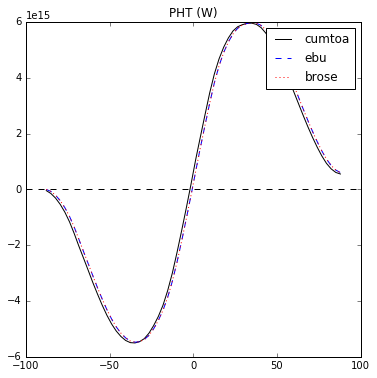

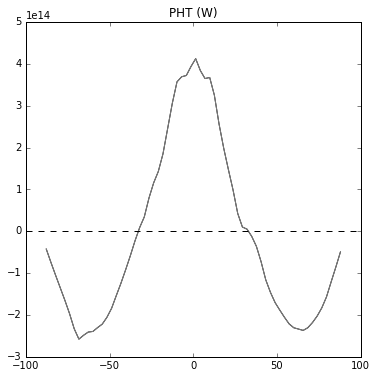

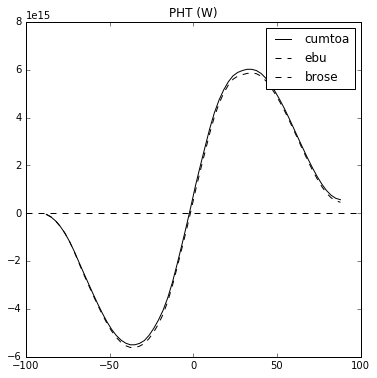

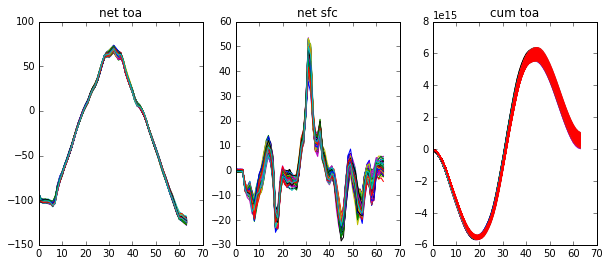

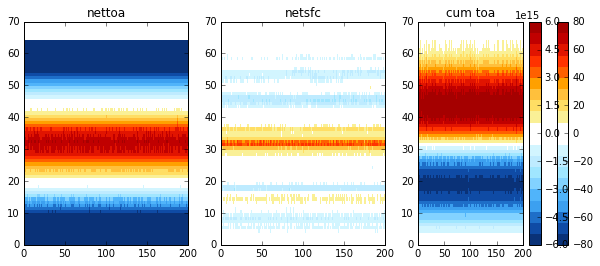

In [78]:
if timeseries:
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(lat,cumtoa[-5,:],color='k')
    ax.plot(lat,testtot[-5,:],color='b',linestyle='dashed')
    ax.plot(lat,brtot[-5,:],color='r',linestyle='dotted')
    ax.axhline(y=0,color='k',linestyle='dashed')
    ax.set_title('PHT (W)')
    ax.legend(('cumtoa','ebu','brose'))

    fig,ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(lat,cumtoa[-1,:]-brtot[-1,:],color='k')
    ax.plot(lat,cumtoa[-1,:]-testtot[-1,:],color='0.5')
    ax.axhline(y=0,color='k',linestyle='dashed')
    ax.set_title('PHT (W)')
    
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(lat,cumtoa[0,:],color='k')
    ax.plot(lat,cumtoa[-1,:],color='k',linestyle='dashed')
    #ax.plot(lat,testtot[-5,:],color='b',linestyle='dashed')
    #ax.plot(lat,brtot[-5,:],color='r',linestyle='dotted')
    ax.axhline(y=0,color='k',linestyle='dashed')
    ax.set_title('PHT (W)')
    ax.legend(('cumtoa','ebu','brose'))
    
    
    
    fig,axs = plt.subplots(1,3, figsize=(10,4))
    ax=axs[0]
    ax.plot(nettoa.T)
    ax.set_title('net toa')
    
    ax=axs[1]
    ax.plot(netsfc.T)
    ax.set_title('net sfc')
    
    ax=axs[2]
    ax.plot(cumtoa.T)
    ax.plot(testtot.T,color='0.5')
    ax.plot(brtot.T,color='r')
    ax.set_title('cum toa')
    
    fig,axs = plt.subplots(1,3, figsize=(10,4))
    ax=axs[0]
    pc = ax.pcolor(nettoa.T,**pparams)
    ax.set_title('nettoa')

    ax=axs[1]
    pc = ax.pcolor(netsfc.T,**pparams)
    ax.set_title('netsfc')
    plt.colorbar(pc)
    
    ax=axs[2]
    pc = ax.pcolor(cumtoa.T,cmap=plt.cm.get_cmap(cmap), vmin=-6e15, vmax=6e15)
    ax.set_title('cum toa')
    plt.colorbar(pc)

In [45]:
latrad=np.deg2rad(lat)
print np.diff(latrad)

[ 0.04829802  0.04858312  0.04864756  0.04867193  0.04868392  0.04869044
  0.04869457  0.0486971   0.0486991   0.04870036  0.04870136  0.04870209
  0.04870276  0.04870316  0.04870356  0.04870389  0.04870416  0.04870429
  0.04870456  0.04870462  0.04870479  0.04870489  0.04870499  0.04870506
  0.04870509  0.04870517  0.04870522  0.04870524  0.04870526  0.04870529
  0.0487053   0.04870539  0.0487053   0.04870529  0.04870526  0.04870524
  0.04870522  0.04870517  0.04870509  0.04870506  0.04870499  0.04870489
  0.04870479  0.04870462  0.04870456  0.04870429  0.04870416  0.04870389
  0.04870356  0.04870316  0.04870276  0.04870209  0.04870136  0.04870036
  0.0486991   0.0486971   0.04869457  0.04869044  0.04868392  0.04867193
  0.04864756  0.04858312  0.04829802]


In [22]:

print casename

# ================= PLOT COMPONENTS OF ENERGY BUDGET =====
# ========================================================

if not timeseries:
    # ############# TOA
    fig,axs=plt.subplots(1,3)
    fig.set_size_inches((12,4))

    ax=axs[0]
    ax.plot(lat,toadf['fso'] - toadf['fsr'],'r',linewidth=2)
    ax.plot(lat,toadf['olr'],'b',linewidth=2)
    ax.set_xlim((-90,90))
    ax.legend(('Net incoming SW','OLR'),frameon=False,loc='best')
    ax.set_title('TOA Radiation [W/m2]')

    ax=axs[1]
    ax.plot(lat,toadf['fso'] - toadf['fsr'] - toadf['olr'],'k',linewidth=2)
    ax.axhline(y=0,color='k')
    ax.set_xlim((-90,90))
    ax.set_title('Net TOA Radiation [W/m2]')

    ax=axs[2]
    ax.plot(lat,np.cumsum(nettoa*latcircles),'k',linewidth=2)
    ax.set_xlim((-90,90))
    ax.axhline(y=0,color='k')
    ax.set_title('Implied Total PHT [W]')

    print 'Integrated TOA flux should give 0'
    print 'Residual TOA [PW]: ' + str(np.sum(nettoa*latcircles)/1e15)
    print 'Residual TOA [W/m2]: ' + str(np.sum(nettoa*coslat))

    # ########### SURFACE
    fig,axs=plt.subplots(1,3)
    fig.set_size_inches((12,4))

    ax=axs[0]
    ax.plot(lat,sfcdf['fsg']+sfcdf['flg'],color='orange',linewidth=2)
    ax.plot(lat,sfcdf['hfs']+sfcdf['hfl'],color='green',linewidth=2)
    ax.set_xlim((-90,90))
    ax.axhline(y=0,color='k')
    ax.legend(('Net rad','Turb'),frameon=False,loc='best')
    ax.set_title('Surface fluxes [W/m2]')

    ax=axs[1]
    ax.plot(lat,sfcdf['fsg']+sfcdf['flg']-(sfcdf['hfs']+sfcdf['hfl']),'k',linewidth=2)
    ax.set_title('Net Surface Fluxes [W/m2]')
    ax.set_xlim((-90,90))
    ax.axhline(y=0,color='k')

    ax=axs[2]
    ax.plot(lat,np.cumsum(netsfc*latcircles),'k',linewidth=2)
    ax.set_xlim((-90,90))
    ax.axhline(y=0,color='k')
    ax.set_title('Implied Ocean(?) PHT [W]')

    print 'Residual Sfc [PW]: ' + str(np.sum(netsfc*latcircles)/1e15)
    print 'Residual Sfc [W/m2]: ' + str(np.sum(netsfc*coslat))


2xco2preiice


In [23]:
# Compare direct calculation of PHT with indirect calc (w/ toa/sfc fluxes)
# Compare with Fasullo & Trenberth Fig 7d and Wunsch Fig 1 above

printtofile=False
if not timeseries:
    fig,ax=plt.subplots(1,1) # got rid of zonal avg
    fig.set_size_inches((6,5))

    ax.plot(lat,np.cumsum(nettoa*latcircles)/1e15,'k',linewidth=3)
    ax.plot(lat,np.cumsum(netsfc*latcircles)/1e15,'k',linewidth=2,linestyle='-.')
    ax.plot(lat,(np.cumsum(nettoa*latcircles)-np.cumsum(netsfc*latcircles))/1e15,
            'k',linewidth=2,linestyle='--')
    # Add curves from Direct calculation above. Fudge the order of magnitude.
    #ax.plot(lat,fldzatot/1e14,color='b', linewidth=2) # calc w/ the vert integral done in script
    #@@@@ax.plot(lat,fldzatot2/1e14,color='r', linewidth=2) # calc w/ the vert integral done in .nc (diags)
    ax.plot(lat,fldtot2/1e15,color='r',linewidth=2) # zonal INTEGRAL
    ax.set_xlim((-90,90))
    ax.axhline(y=0,color='k')
    ax.set_title('Poleward heat transport [PW]')
    ax.legend(('Total','Ocean','Atmos residual','Atmos direct zonal int'), frameon=False,loc='best')#'Atmos direct*10'

    if printtofile:
        fig.savefig(casename + '_PHT_fromfluxes_comptodirectzonaltot.pdf')
    